## Run benchmarks

In [1]:
import os

In [2]:
os.environ['SPARK_HOME'] = '/cluster/home/roskarr/spark'

In [3]:
import findspark
findspark.init()

import sparkhpc
import pyspark
import time
import csv

In [5]:
sj = sparkhpc.sparkjob.LSFSparkJob(jobid=31640721)
#sj.submit()

In [6]:
sj.job_started()

True

In [11]:
sj.prop_dict

{'config_dir': None,
 'follow_up_script': '',
 'jobid': '31640721',
 'jobname': 'sparkcluster',
 'memory': '2000',
 'ncores': '4',
 'spark_home': '/cluster/home/roskarr/spark',
 'status': None,
 'template': None,
 'walltime': '00:30'}

In [7]:
sc = pyspark.SparkContext(master=sj.master_url())

In [8]:
import cnat

In [ ]:
for n in [800000,1600000,3200000]:
    strings = cnat.random_strings.generate_random_sequences(n)
    timein = time.time()
    mat = cnat.process_strings.produce_network(strings, min_ld=1, max_ld=10, sc=sc)
    mat.count()
    timeout = time.time()
    with open('../cdr3_analyze_benchmark.csv','a') as f:
        writer = csv.DictWriter(f, fieldnames = ['nstrings', 'ncores', 'spark', 'type', 'min_ld', 'max_ld', 'dt'])
        writer.writerow({'nstrings': n, 'spark': True, 'ncores': 160, 'dt': timeout-timein, 'type': 'graph',
                                 'min_ld': 1, 'max_ld':10})

## Plot runtime results

In [2]:
import pandas as pd
import matplotlib.pylab as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.rcParams['text.usetex']= False

In [4]:
plt.rcParams['figure.figsize'] = [10,8]
#plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='x-large'

In [5]:
df = pd.read_csv('../cdr3_analyze_benchmark.csv', index_col='nstrings')

In [8]:
df = df[(df.index>=100000) & (df.index < 2000000) & (df['ncores']>20)].sort_values(by=['ncores']).sort_index()[['dt','ncores']]#[df['ncores']<300]

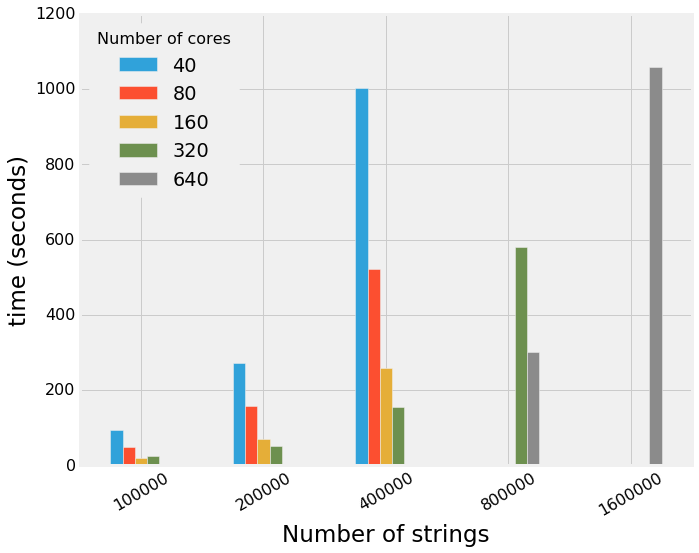

In [9]:
ax = df.pivot(columns='ncores').plot.bar()
plt.xlabel('Number of strings')
plt.legend(['40','80','160','320','640'], loc='upper left', title='Number of cores')
plt.ylabel('time (seconds)')
ax.set_xticklabels(df.index.unique(), rotation=30)
plt.tight_layout()
plt.savefig('compute_scaling.png')

In [10]:
df.to_csv('timing_data.csv')

## Trying Altair

In [1]:
import pandas as pd

In [146]:
import altair
from altair import Chart, X, Y, Color, Column, Scale, expr, Axis, Formula, Legend, LegendConfig

In [ ]:
LegendConfi

In [42]:
df = pd.read_csv('../cdr3_analyze_benchmark.csv')

In [84]:
df.head()

,nstrings,ncores,spark,type,min_ld,max_ld,dt
0,100,10,True,graph,1,10,0.002437
1,215,10,True,graph,1,10,0.010117
2,464,10,True,graph,1,10,0.046256
3,1000,10,True,graph,1,10,0.227567
4,2154,10,True,graph,1,10,8.599866


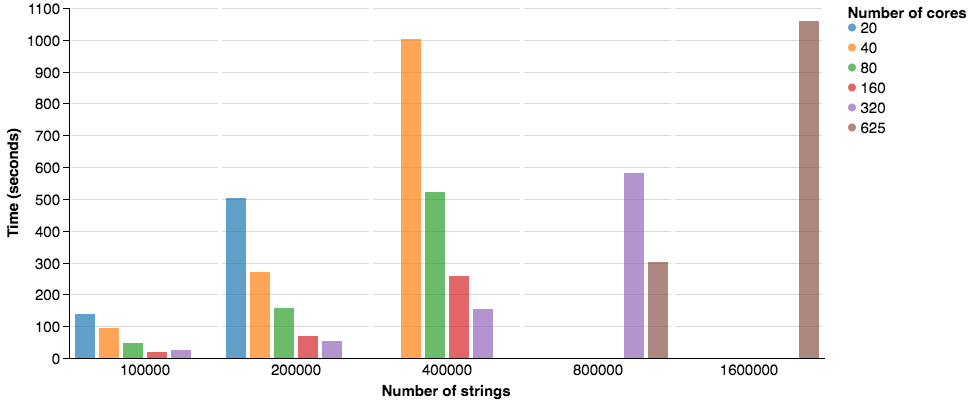

In [165]:
Chart(df[['ncores','nstrings','dt']]).mark_bar().encode(
    color=Color('ncores:N', legend=Legend(title=u'Number of cores')),
    column=Column('nstrings:O',
        axis=Axis(
            axisWidth=1.0,
            offset=-8.0,
            orient='bottom',
            title='Number of strings',
            tickLabelFontSize=15.,
            titleFontSize=15
        ),
        scale=Scale(
            padding=4.0,
        )
    ),
    x=X('ncores:O',
        axis=False),
    y=Y('dt',
        axis=Axis(format='f',
                  title='Time (seconds)', 
                  tickLabelFontSize=15,
                  titleFontSize=15),
        ),
).transform_data(
    filter=((expr.df.nstrings >= 100000) & (expr.df.ncores > 10))
).configure_facet_cell(
    strokeWidth=0.0,
).configure_legend(
    labelFontSize=15,
    titleFontSize=15,
)